In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
sns.set_palette("husl")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
data_path = Path("../data")

try:
    games_df = pd.read_csv(data_path / "games.csv", encoding='utf-8')
    user_ratings_df = pd.read_csv(data_path / "user_ratings.csv", encoding='utf-8')
    ratings_dist_df = pd.read_csv(data_path / "ratings_distribution.csv", encoding='utf-8')
    mechanics_df = pd.read_csv(data_path / "mechanics.csv", encoding='utf-8')
    
except FileNotFoundError as e:
    print(f"✗ 오류: {e}")
    raise
except UnicodeDecodeError:
    games_df = pd.read_csv(data_path / "games.csv", encoding='cp949')
    user_ratings_df = pd.read_csv(data_path / "user_ratings.csv", encoding='cp949')
    ratings_dist_df = pd.read_csv(data_path / "ratings_distribution.csv", encoding='cp949')
    mechanics_df = pd.read_csv(data_path / "mechanics.csv", encoding='cp949')

In [4]:
datasets = [
    ("games.csv", games_df),
    ("user_ratings.csv", user_ratings_df),
    ("ratings_distribution.csv", ratings_dist_df),
    ("mechanics.csv", mechanics_df)
]

for name, df in datasets:
    print(f"\n {name}")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {list(df.columns)}")
    print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

for name, df in datasets:
    print("\n" + "="*70)
    print(f" {name} 상세:")
    print(df.head(3))
    print(f"\n데이터 타입:")
    print(df.dtypes)
    print(f"\n기술 통계:")
    print(df.describe())


 games.csv
   Shape: (21925, 48)
   Columns: ['BGGId', 'Name', 'Description', 'YearPublished', 'GameWeight', 'AvgRating', 'BayesAvgRating', 'StdDev', 'MinPlayers', 'MaxPlayers', 'ComAgeRec', 'LanguageEase', 'BestPlayers', 'GoodPlayers', 'NumOwned', 'NumWant', 'NumWish', 'NumWeightVotes', 'MfgPlaytime', 'ComMinPlaytime', 'ComMaxPlaytime', 'MfgAgeRec', 'NumUserRatings', 'NumComments', 'NumAlternates', 'NumExpansions', 'NumImplementations', 'IsReimplementation', 'Family', 'Kickstarted', 'ImagePath', 'Rank:boardgame', 'Rank:strategygames', 'Rank:abstracts', 'Rank:familygames', 'Rank:thematic', 'Rank:cgs', 'Rank:wargames', 'Rank:partygames', 'Rank:childrensgames', 'Cat:Thematic', 'Cat:Strategy', 'Cat:War', 'Cat:Family', 'Cat:CGS', 'Cat:Abstract', 'Cat:Party', 'Cat:Childrens']
   Memory: 29.61 MB

 user_ratings.csv
   Shape: (18942215, 3)
   Columns: ['BGGId', 'Rating', 'Username']
   Memory: 1333.89 MB

 ratings_distribution.csv
   Shape: (21925, 96)
   Columns: ['BGGId', '0.0', '0.1', '0.

### SQLite 데이터베이스 생성

In [5]:
db_path = data_path / "boardgame.db"
conn = sqlite3.connect(db_path)

games_df.to_sql('games', conn, if_exists='replace', index=False)
user_ratings_df.to_sql('user_ratings', conn, if_exists='replace', index=False)
ratings_dist_df.to_sql('ratings_distribution', conn, if_exists='replace', index=False)
mechanics_df.to_sql('mechanics', conn, if_exists='replace', index=False)

print(f"SQLite 데이터베이스 생성: {db_path}")

tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print(f"생성된 테이블: {list(tables['name'])}")


SQLite 데이터베이스 생성: ..\data\boardgame.db
생성된 테이블: ['games', 'user_ratings', 'ratings_distribution', 'mechanics']


### 사용자 활동 

In [7]:
user_col = 'Username'
game_col = 'BGGId'
rating_col = 'Rating'

print(f"{user_col}, {game_col}, {rating_col}")

query_user_activity = f"""
SELECT 
    {user_col} as user_id,
    COUNT(*) as total_ratings,
    ROUND(AVG({rating_col}), 2) as avg_rating,
    MIN({rating_col}) as min_rating,
    MAX({rating_col}) as max_rating,
    ROUND(AVG({rating_col}) * COUNT(*), 2) as engagement_score
FROM user_ratings
GROUP BY {user_col}
HAVING total_ratings >= 50
ORDER BY total_ratings DESC
LIMIT 20
"""

top_users = pd.read_sql_query(query_user_activity, conn)
print("\n가장 활발한 사용자 Top 20:")
print(top_users)

print(f"\n사용자 활동 요약:")
print(f"   - 50개 이상 평가한 사용자: {len(top_users):,}명")
print(f"   - 최대 평가 수: {top_users['total_ratings'].max():,}개")
print(f"   - 평균 평가 수: {top_users['total_ratings'].mean():.1f}개")
print(f"   - 전체 사용자 수: {user_ratings_df[user_col].nunique():,}명")

Username, BGGId, Rating

가장 활발한 사용자 Top 20:
           user_id  total_ratings  avg_rating  min_rating  max_rating  \
0   oldgoat3769967           6493        6.20         1.0       10.00   
1            warta           6247        7.23         1.0       10.00   
2     leffe dubbel           6047        5.95         1.0       10.00   
3         TomVasel           5706        6.42         1.0       10.00   
4             Doel           5226        7.51         2.0       10.00   
5          Hessu68           5036        5.81         2.0       10.00   
6      Walt Mulder           4887        7.46         1.0       10.00   
7             fake           4275        6.13         1.0       10.00   
8          Tolkana           4078        9.20         1.0       10.00   
9            Nap16           3974        6.56         1.0       10.00   
10         Be4tngU           3858        5.43         3.0        9.00   
11        mcpranno           3643        5.90         1.0       10.00   
12    J

### 게임 인기도

In [8]:
query_popular_games = f"""
SELECT 
    {game_col} as game_id,
    COUNT(*) as rating_count,
    ROUND(AVG({rating_col}), 2) as avg_rating,
    ROUND(AVG({rating_col}) * COUNT(*), 2) as popularity_score
FROM user_ratings
GROUP BY {game_col}
HAVING rating_count >= 20
ORDER BY avg_rating DESC, rating_count DESC
LIMIT 20
"""

popular_games = pd.read_sql_query(query_popular_games, conn)
print("\n평점이 높은 인기 게임 Top 20:")
print(popular_games)

print(f"\n게임 인기도 요약:")
print(f"   - 20개 이상 평가받은 게임: {len(popular_games):,}개")
print(f"   - 최고 평점: {popular_games['avg_rating'].max():.2f}")
print(f"   - 최다 평가 게임 평가 수: {popular_games['rating_count'].max():,}개")
print(f"   - 전체 게임 수: {user_ratings_df[game_col].nunique():,}개")


평점이 높은 인기 게임 Top 20:
    game_id  rating_count  avg_rating  popularity_score
0    284121           100        9.73            973.22
1    295785           300        9.64           2891.32
2    342942           700        9.63           6743.77
3    249277           200        9.53           1906.00
4    275777            44        9.52            419.00
5    345976            48        9.46            454.00
6    228370            70        9.43            660.00
7    341169           500        9.35           4675.69
8    256885           387        9.33           3610.50
9    173514            45        9.31            419.00
10    85147           101        9.29            938.50
11   281257            40        9.25            370.00
12   207203            58        9.24            536.00
13   151070            31        9.23            286.05
14   323947           199        9.22           1833.95
15   165694            37        9.22            341.00
16   277659           300 

### 평점 분포

In [9]:
query_rating_distribution = f"""
SELECT 
    CAST({rating_col} AS INTEGER) as rating_bucket,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM user_ratings), 2) as percentage
FROM user_ratings
GROUP BY rating_bucket
ORDER BY rating_bucket DESC
"""

rating_dist = pd.read_sql_query(query_rating_distribution, conn)
print("\n평점 분포:")
print(rating_dist)


평점 분포:
    rating_bucket    count  percentage
0              10   944321        4.99
1               9  1979653       10.45
2               8  4373568       23.09
3               7  5573456       29.42
4               6  3556468       18.78
5               5  1454004        7.68
6               4   604723        3.19
7               3   281374        1.49
8               2   118008        0.62
9               1    56632        0.30
10              0        8        0.00


### 데이터 희소성

In [10]:
unique_users = user_ratings_df[user_col].nunique()
unique_games = user_ratings_df[game_col].nunique()
total_ratings = len(user_ratings_df)

total_possible = unique_users * unique_games
sparsity = (1 - total_ratings / total_possible) * 100

print(f"\n데이터 희소성 분석:")
print(f"   - 고유 사용자 수: {unique_users:,}")
print(f"   - 고유 게임 수: {unique_games:,}")
print(f"   - 총 평점 수: {total_ratings:,}")
print(f"   - 가능한 조합 수: {total_possible:,}")
print(f"   - 희소성(Sparsity): {sparsity:.6f}%")
print(f"   - 밀도(Density): {100-sparsity:.6f}%")

actual_ratings = total_ratings


데이터 희소성 분석:
   - 고유 사용자 수: 411,374
   - 고유 게임 수: 21,925
   - 총 평점 수: 18,942,215
   - 가능한 조합 수: 9,019,374,950
   - 희소성(Sparsity): 99.789983%
   - 밀도(Density): 0.210017%


### 사용자 세분화

In [11]:
user_stats = user_ratings_df.groupby(user_col).agg({
    rating_col: ['count', 'mean']
}).reset_index()
user_stats.columns = [user_col, 'total_ratings', 'avg_rating']

def classify_user(count):
    if count >= 100:
        return 'Power User'
    elif count >= 50:
        return 'Active User'
    elif count >= 10:
        return 'Regular User'
    else:
        return 'Casual User'

user_stats['user_segment'] = user_stats['total_ratings'].apply(classify_user)

user_segments = user_stats.groupby('user_segment').agg({
    user_col: 'count',
    'total_ratings': 'mean',
    'avg_rating': 'mean'
}).reset_index()
user_segments.columns = ['user_segment', 'user_count', 'avg_ratings', 'avg_score']
user_segments = user_segments.sort_values('avg_ratings', ascending=False)

print("\n사용자 세그먼트 분석:")
print(user_segments)


사용자 세그먼트 분석:
   user_segment  user_count  avg_ratings  avg_score
2    Power User       48395   248.175142   7.051560
0   Active User       45242    70.107533   7.333490
3  Regular User      130967    24.362977   7.621304
1   Casual User      186770     3.047411   8.554858


### Data Quality

In [12]:
def check_data_quality(df, name):
    print(f"\n{name}")
    print(f"   총 행 수: {len(df):,}")
    print(f"   중복 행 수: {df.duplicated().sum():,}")
    
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print(f"   결측치: 없음")
    else:
        print(f"   결측치:")
        for col, count in missing[missing > 0].items():
            print(f"      {col}: {count:,} ({count/len(df)*100:.2f}%)")

for name, df in datasets:
    check_data_quality(df, name)


games.csv
   총 행 수: 21,925
   중복 행 수: 0
   결측치:
      Description: 1 (0.00%)
      ComAgeRec: 5,530 (25.22%)
      LanguageEase: 5,891 (26.87%)
      Family: 15,262 (69.61%)
      ImagePath: 17 (0.08%)

user_ratings.csv
   총 행 수: 18,942,215
   중복 행 수: 0
   결측치:
      Username: 63 (0.00%)

ratings_distribution.csv
   총 행 수: 21,925
   중복 행 수: 0
   결측치: 없음

mechanics.csv
   총 행 수: 21,925
   중복 행 수: 0
   결측치: 없음


### 시각화

In [13]:
output_path = Path("../outputs/figures")
output_path.mkdir(parents=True, exist_ok=True)

저장: ..\outputs\figures\01_rating_analysis.png


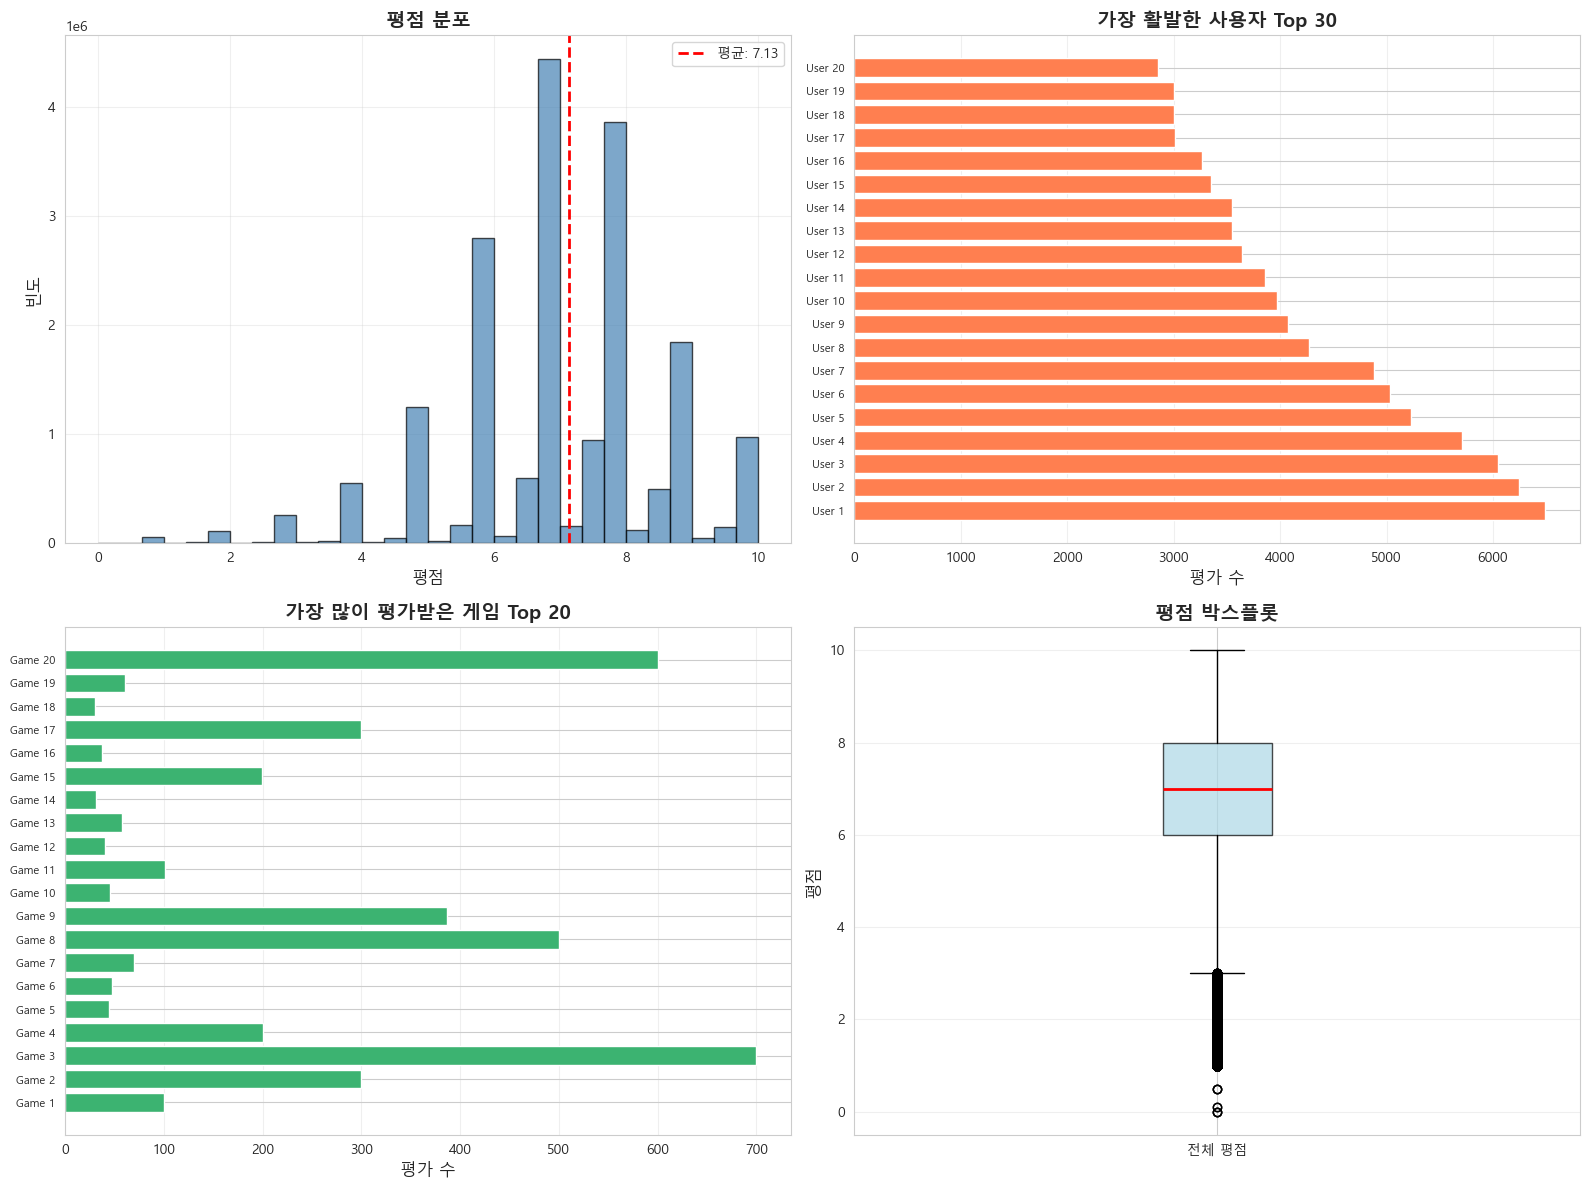

In [22]:

# Figure 1: 평점 분석 (4개 서브플롯)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 평점 히스토그램
axes[0, 0].hist(user_ratings_df[rating_col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(user_ratings_df[rating_col].mean(), color='red', 
                    linestyle='--', linewidth=2, label=f'평균: {user_ratings_df[rating_col].mean():.2f}')
axes[0, 0].set_xlabel('평점', fontsize=12)
axes[0, 0].set_ylabel('빈도', fontsize=12)
axes[0, 0].set_title('평점 분포', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 사용자당 평점 수
user_rating_counts = top_users.head(30)
axes[0, 1].barh(range(len(user_rating_counts)), user_rating_counts['total_ratings'], color='coral')
axes[0, 1].set_yticks(range(len(user_rating_counts)))
axes[0, 1].set_yticklabels([f"User {i+1}" for i in range(len(user_rating_counts))], fontsize=8)
axes[0, 1].set_xlabel('평가 수', fontsize=12)
axes[0, 1].set_title('가장 활발한 사용자 Top 30', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 게임 인기도
top_20_games = popular_games.head(20)
axes[1, 0].barh(range(len(top_20_games)), top_20_games['rating_count'], color='mediumseagreen')
axes[1, 0].set_yticks(range(len(top_20_games)))
axes[1, 0].set_yticklabels([f"Game {i+1}" for i in range(len(top_20_games))], fontsize=8)
axes[1, 0].set_xlabel('평가 수', fontsize=12)
axes[1, 0].set_title('가장 많이 평가받은 게임 Top 20', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 평점 박스플롯
bp = axes[1, 1].boxplot(user_ratings_df[rating_col], vert=True, patch_artist=True,
                         boxprops=dict(facecolor='lightblue', alpha=0.7),
                         medianprops=dict(color='red', linewidth=2))
axes[1, 1].set_ylabel('평점', fontsize=12)
axes[1, 1].set_title('평점 박스플롯', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_xticklabels(['전체 평점'])

plt.tight_layout()
plt.savefig(output_path / '01_rating_analysis.png', dpi=300, bbox_inches='tight')
print(f"저장: {output_path / '01_rating_analysis.png'}")
plt.show()
plt.close()


저장: ..\outputs\figures\02_sparsity_segments.png


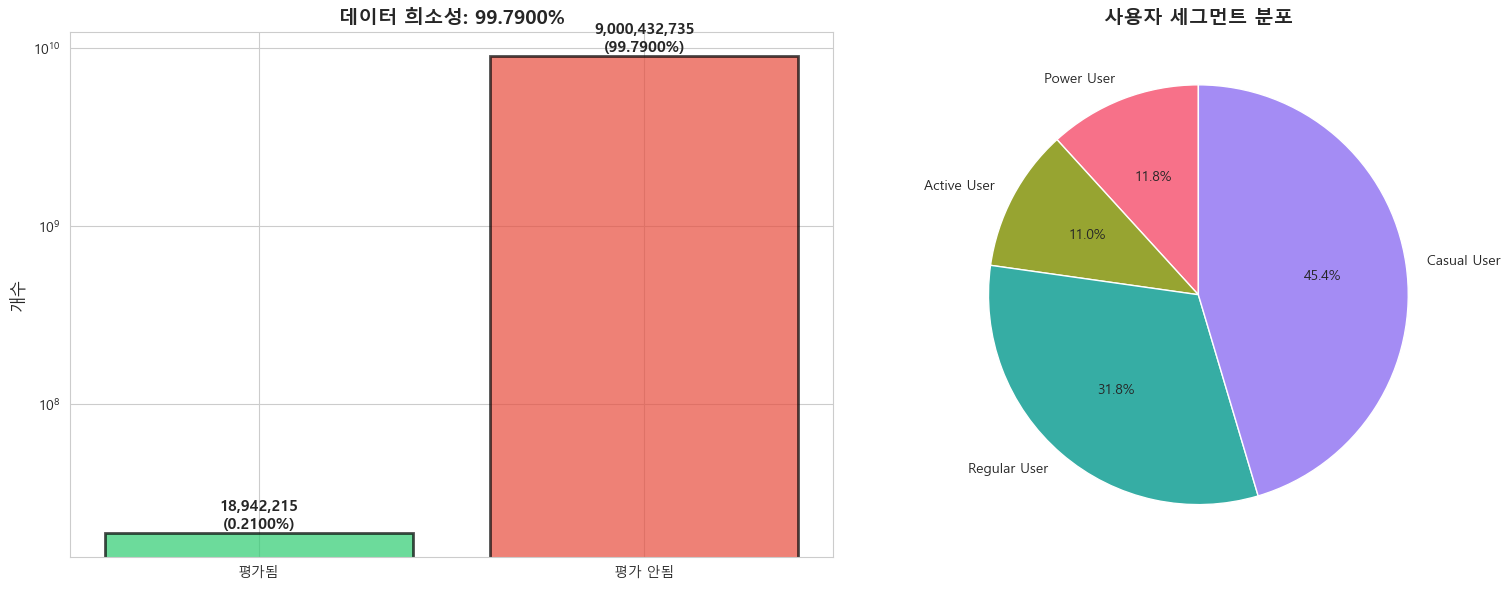

In [21]:

# Figure 2: 데이터 희소성 및 세그먼트
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 희소성 바 차트
data_labels = ['평가됨', '평가 안됨']
values = [actual_ratings, total_possible - actual_ratings]
colors = ['#2ecc71', '#e74c3c']

bars = axes[0].bar(data_labels, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('개수', fontsize=12)
axes[0].set_title(f'데이터 희소성: {sparsity:.4f}%', fontsize=14, fontweight='bold')
axes[0].set_yscale('log')

for i, (bar, v) in enumerate(zip(bars, values)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{v:,}\n({v/total_possible*100:.4f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# 사용자 세그먼트 파이 차트
axes[1].pie(user_segments['user_count'], labels=user_segments['user_segment'],
           autopct='%1.1f%%', startangle=90, colors=sns.color_palette("husl", len(user_segments)))
axes[1].set_title('사용자 세그먼트 분포', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(output_path / '02_sparsity_segments.png', dpi=300, bbox_inches='tight')
print(f"저장: {output_path / '02_sparsity_segments.png'}")
plt.show()
plt.close()

### Summary

In [18]:
output_reports_path = Path("../outputs/reports")
output_reports_path.mkdir(parents=True, exist_ok=True)

summary_stats = {
    'Dataset': ['games', 'user_ratings', 'ratings_distribution', 'mechanics'],
    'Rows': [len(games_df), len(user_ratings_df), len(ratings_dist_df), len(mechanics_df)],
    'Columns': [len(games_df.columns), len(user_ratings_df.columns), 
                len(ratings_dist_df.columns), len(mechanics_df.columns)],
    'Missing Values': [games_df.isnull().sum().sum(), user_ratings_df.isnull().sum().sum(),
                       ratings_dist_df.isnull().sum().sum(), mechanics_df.isnull().sum().sum()]
}
summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv(output_reports_path / 'data_summary.csv', index=False)
print(f"저장: {output_reports_path / 'data_summary.csv'}")

top_users.to_csv(output_reports_path / 'top_users.csv', index=False)
popular_games.to_csv(output_reports_path / 'popular_games.csv', index=False)
user_segments.to_csv(output_reports_path / 'user_segments.csv', index=False)

conn.close()

저장: ..\outputs\reports\data_summary.csv


In [19]:
print("\n핵심 발견사항:")
print(f"   1. 총 평점 데이터: {total_ratings:,}개")
print(f"   2. 사용자 수: {unique_users:,}명")
print(f"   3. 게임 수: {unique_games:,}개")
print(f"   4. 데이터 희소성: {sparsity:.6f}%")
print(f"   5. 평균 평점: {user_ratings_df[rating_col].mean():.3f}")
print(f"   6. 사용자 세그먼트: {len(user_segments)}개 그룹")
print(f"   7. 평점 범위: {user_ratings_df[rating_col].min():.1f} ~ {user_ratings_df[rating_col].max():.1f}")

print(f"\n생성된 파일:")
print(f"   [데이터베이스]")
print(f"   - {db_path}")
print(f"   [시각화]")
print(f"   - {output_path / '01_rating_analysis.png'}")
print(f"   - {output_path / '02_sparsity_segments.png'}")
print(f"   [보고서]")
print(f"   - {output_reports_path / 'data_summary.csv'}")
print(f"   - {output_reports_path / 'top_users.csv'}")
print(f"   - {output_reports_path / 'popular_games.csv'}")
print(f"   - {output_reports_path / 'user_segments.csv'}")


핵심 발견사항:
   1. 총 평점 데이터: 18,942,215개
   2. 사용자 수: 411,374명
   3. 게임 수: 21,925개
   4. 데이터 희소성: 99.789983%
   5. 평균 평점: 7.131
   6. 사용자 세그먼트: 4개 그룹
   7. 평점 범위: 0.0 ~ 10.0

생성된 파일:
   [데이터베이스]
   - ..\data\boardgame.db
   [시각화]
   - ..\outputs\figures\01_rating_analysis.png
   - ..\outputs\figures\02_sparsity_segments.png
   [보고서]
   - ..\outputs\reports\data_summary.csv
   - ..\outputs\reports\top_users.csv
   - ..\outputs\reports\popular_games.csv
   - ..\outputs\reports\user_segments.csv
